In [94]:
%run LM_PBM_Radau.ipynb
import pandas as pd
import matplotlib.pyplot as plt

# Data import

In [60]:
df = pd.read_csv('particle_size.csv')
data = df.to_numpy()
L = data[:,0]
V = data[:,1:]/100   # Convert probability to density
Nbr = np.empty(np.shape(V)) # Number density
df2 = pd.read_csv('lognormal.csv')
data2 = df2.to_numpy()
mu = data2[0:4,-1]
sigma = data2[4:,-1]
T = np.array([0.,44.,88.,154.,330.,551.])
k0 = np.array([1e-7,0.8,0.15])

## Dimensions
n: Dimension of particle sizes. dim(L)

N: Dimension of time. dim(T)

p: Dimension of parameters. dim(k)

dim(V) = dim(ND) = n*N

In [3]:
n = np.size(L)
N = np.size(T)
p = np.size(k0)

## Weighting matrix
$$Q_{ii} = l_i^3$$

In [4]:
Q = np.diag(L**3)

# Convert volume to number
Simple relation between volume and number
\begin{equation}
V_i=N_i\times l_i^3
\end{equation}
was assumed.

In [5]:
for i in range(N):
    Nbr[:,i] = np.divide(V[:,i],L**3)

## Moments

In [6]:
N0 = Nbr[:,0]
m00 = np.sum(N0)
m10 = np.sum(L@N0)
m20 = np.sum(np.power(L,2)@N0)
m30 = np.sum(np.power(L,3)@N0)
Y0 = np.append(N0,[m00,m10,m20,m30])

### Log-normal distribution of breakage function
The probability distribution of volume of particle size of $x$ produced by the breakage of particle size of $l$ is $P(x|l)$. Then
\begin{equation} \label{eq:prob}
\int_0^lP(x|l)dx=1
\end{equation}
This means sum of all particles' volume is same with the volume of original particle. Assuming that volume of original particle $l^3$ and that of broken particle $x^3$ the breakage function which is the number of particles produced by the breakage of original particle is
\begin{equation}
b(x,l)=\left(\frac{l}{x}\right)^3P(x|l)
\end{equation}
For mass or volume conservation, sum of all particle volumes generated by a particle of size $l$ should be $l^3$. That is
\begin{equation}
\int_0^lx^3b(x,l)dx=l^3
\end{equation}
which is just equivalent with eq. \ref{eq:prob}.\\
Deconvolution of particle size distribution (PSD) of activted sludge shows clear modes of log-normal distribution so that $\ln(L)\sim N(\mu,\sigma)$. Hence, the breakage function is
\begin{equation}
b(x,l)=\left(\frac{l}{x}\right)^3\frac{\frac{1}{x\sigma\sqrt{2\pi}}\exp\left(-\frac{\left(\ln x-\mu\right)^2}{2\sigma^2}\right)}{\frac{1}{2}\text{erfc}\left(-\frac{\ln l-\mu}{\sqrt{2}\sigma}\right)}
\end{equation}

In [7]:
from scipy.special import erfc
def lognorm_b(x,l,mu,sigma):
    assert sigma > 0, "sigma must be larger than 0"
    def lnpdf(x,m,sg):
        num = np.exp(-(np.log(x)-m)**2/(2*sg**2))
        den = x*sg*np.sqrt(2*np.pi)
        return num/den
    num = lnpdf(x,mu,sigma)
    den = erfc(-(np.log(l)-mu)/(np.sqrt(2)*sigma))/2
    # In case 'l' is too small compared to 'mu',
    # 'den' can be numerically zero 
    # if it is smaller than the machine precision epsilon 
    # which is not correct theoretically
    if den == 0:
        den = np.finfo(float).eps
    # convert volume to number
    return (l/x)**3*num/den

## Breakage function by log normal distribution

## Selection function
Selection rate function by size dependent
\begin{equation}
S(l)=S_0l^p
\end{equation}

In [8]:
def break_lognormal(x,l,k):
    bf=k[1]*lognorm_b(x,l,mu[1],sigma[1])+k[2]*lognorm_b(x,l,mu[2],sigma[2])\
       +(1-k[1]-k[2])*lognorm_b(x,l,mu[3],sigma[3])
    return bf

def selection_szdp(l,k):
    return k[0]*l**3

In [87]:
import time
start = time.time()
k = k0.copy()
delta = 1e-8
dbs = discretize(break_lognormal, selection_szdp, L, n, p, k, delta)
print(time.time()-start)

discretizing
265.71135234832764


In [90]:
start = time.time()
Y, Jt, S, r, fail = checkSrJ(breakage, Nbr, dbs, T, n, p, N, Q, 1e8, False, delta)
print(time.time()-start)

start loop
0


ValueError: array must not contain infs or NaNs

In [40]:
VV = np.empty(np.shape(Nbr))
for i in range(6):
    VV[:,i] = np.multiply(Y[:,i],L**3)

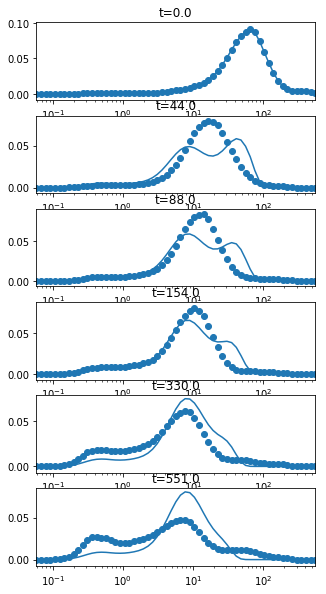

In [41]:
fig, axes = plt.subplots(6,1,figsize=(5,10))
for i in range(6):
    axes[i].plot(L,VV[:,i])
    axes[i].scatter(L,V[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))

In [73]:
Z = np.zeros((n*(p+1),N))
Z[0:n,0] = N0.copy()

In [92]:
z = Z[:,0]

In [95]:
sol = integ_breakage(breakage, z, dbs, T, n, p, delta)

0.1906111240386963
0.18375062942504883
0.1933736801147461
0.18940258026123047
0.18721985816955566
0.18778133392333984
0.18793678283691406
0.18716883659362793
0.19127988815307617
0.1948556900024414
0.1904284954071045
0.19150042533874512
0.1978456974029541
0.19525551795959473
0.19157075881958008
0.18970131874084473
0.1944589614868164
0.19067955017089844
0.19142889976501465
0.18974971771240234
0.19169402122497559
0.19023823738098145
0.1923668384552002
0.19358491897583008
0.19167423248291016
0.18998003005981445
0.19082140922546387
0.19491147994995117
0.19075727462768555
0.21052980422973633
0.18714261054992676
0.1900484561920166
0.18889808654785156
0.1901252269744873
0.205322265625
0.1901702880859375
0.18935346603393555
0.20437169075012207
0.19805169105529785
0.18844199180603027
0.1925373077392578
0.1922602653503418
0.1903989315032959
0.19140124320983887
0.18574857711791992
0.1914501190185547
0.18781042098999023
0.18912410736083984
0.1963357925415039
0.18867087364196777
0.18584632873535156


0.18140959739685059
0.18387889862060547
0.18739819526672363
0.18741154670715332
0.185835599899292
0.1888751983642578
0.20725250244140625
0.18723249435424805
0.18650388717651367
0.19648241996765137
0.18763470649719238
0.19510936737060547
0.18941068649291992
0.1944282054901123
0.18722915649414062
0.18451166152954102
0.18635272979736328
0.18476343154907227
0.18590497970581055
0.18753480911254883
0.19906830787658691
0.18826532363891602
0.1874995231628418
0.1863880157470703
0.18941044807434082
0.18794703483581543
0.19570136070251465
0.1934826374053955
0.1891794204711914
0.18834519386291504
0.19481563568115234
0.1870899200439453
0.18558382987976074
0.19282054901123047
0.19327902793884277
0.1862952709197998
0.18708300590515137
0.1931321620941162
0.18452191352844238
0.18465471267700195
0.18960165977478027
0.1995401382446289
0.19726324081420898
0.19163203239440918
0.19087624549865723
0.18299531936645508
0.18402886390686035
0.19303679466247559
0.1953716278076172
0.18752455711364746
0.18611264228

0.1870114803314209
0.19075417518615723
0.18549656867980957
0.19307756423950195
0.18919897079467773
0.1929028034210205
0.18911981582641602
0.19203948974609375
0.19226336479187012
0.18781805038452148
0.19150376319885254
0.1912703514099121
0.18700551986694336
0.19011402130126953
0.19118452072143555
0.18855667114257812
0.1903393268585205
0.18771696090698242
0.1867690086364746
0.18824052810668945
0.1866014003753662
0.18895578384399414
0.18915772438049316
0.18755435943603516
0.18816137313842773
0.18991780281066895
0.18890976905822754
0.2105412483215332
0.19026398658752441
0.18829107284545898
0.1860671043395996
0.18735837936401367
0.1910707950592041
0.19075465202331543
0.19120264053344727
0.18920516967773438
0.19011402130126953
0.1878185272216797
0.1882457733154297
0.18680214881896973
0.18600678443908691
0.1881723403930664
0.18864178657531738
0.18825006484985352
0.19331884384155273
0.18881964683532715
0.19028115272521973
0.18903779983520508
0.1882646083831787
0.18781232833862305
0.18892431259

In [42]:
H, g = Hg(Jt, Q, r, p, N)

In [20]:
K = np.diag(k)
Hr = K @ H @ K
gr = K @ g

In [43]:
h, mu = cholsolve(H, -g, 0, p)
h

array([-1.27556776e-06, -7.12439204e-01,  5.07069932e-01])

In [52]:
k_new = k + h / 100
k_new

array([8.72443224e-08, 7.92875608e-01, 1.55070699e-01])

In [59]:
delta

1e-08

In [61]:
start = time.time()
dbs = discretize(break_lognormal, selection_szdp, L, n, p, k_new, delta)
print(time.time()-start)

discretizing
269.0358853340149


In [69]:
def dydx(t,y):
    return breakage(y,dbs[0],dbs[1])

In [70]:
sol = solve_ivp(dydx,[T[0],T[-1]],N0,method='Radau',t_eval=T)

In [71]:
VV = np.empty(np.shape(Nbr))
for i in range(6):
    VV[:,i] = np.multiply(sol.y[:,i],L**3)

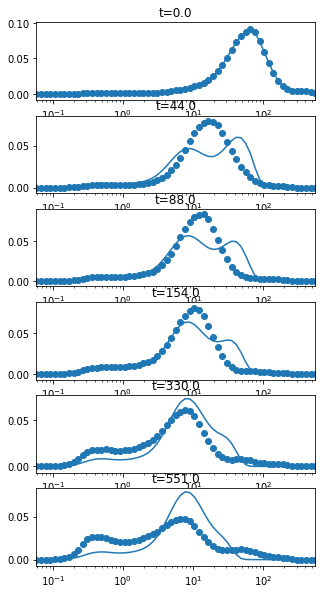

In [72]:
fig, axes = plt.subplots(6,1,figsize=(5,10))
for i in range(6):
    axes[i].plot(L,VV[:,i])
    axes[i].scatter(L,V[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))

In [60]:
res = lm_breakage(breakage, break_lognormal, selection_szdp, 
                  Number, L, Q, k0, T, opts = [1e-10, 1e-8, 1e-8, 100])

discretizing
Iter | Obj func | step size | gradient |   mu   |   rho
    0|3.2531e-02|   Not cal |  Not cal | 9.7e+00| Not cal
discretizing
    1|2.2462e-02|  1.774e-02|  4.98e+03| 3.2e+00| 1.0e+00
discretizing


/home/lsg/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:337: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/home/lsg/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in matmul
/home/lsg/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:346: RuntimeWarning: invalid value encountered in less
  update = max_diff[ind] * scale_new < max_diff_new * scale[ind]
/home/lsg/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:306: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/home/lsg/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:333: RuntimeWarning: invalid value encountered in less
  diff_too_small = max_diff < NUM_JAC_DIFF_REJECT * scale
/home/lsg/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: invalid value encountered in

ValueError: array must not contain infs or NaNs

In [61]:
res

[array([1.78556719e-05, 8.96987055e-01, 5.19196452e-02]),
 array([[ 2.02904200e-03,  1.83051470e-01,  2.11563703e-01,
          2.40473181e-01,  2.90096478e-01,  3.31336298e-01],
        [ 3.27427040e-03,  2.27796198e-02,  2.58204691e-02,
          2.88913445e-02,  3.41332820e-02,  3.84614410e-02],
        [ 4.64727514e-03,  3.26778570e-02,  3.69976738e-02,
          4.13402360e-02,  4.87055619e-02,  5.47410386e-02],
        [ 6.30416170e-03,  4.98320565e-02,  5.64572451e-02,
          6.30839805e-02,  7.42437784e-02,  8.33108807e-02],
        [ 8.60062026e-03,  7.89761633e-02,  8.95780114e-02,
          1.00137689e-01,  1.17813566e-01,  1.32069493e-01],
        [ 1.16224000e-02,  1.22619482e-01,  1.39222909e-01,
          1.55711815e-01,  1.83195755e-01,  2.05246542e-01],
        [ 1.52026801e-02,  1.79416475e-01,  2.03872463e-01,
          2.28115145e-01,  2.68415325e-01,  3.00641776e-01],
        [ 1.89941311e-02,  2.42440502e-01,  2.75630860e-01,
          3.08495602e-01,  3.630413

In [ ]:
def dydx(t,y):
    return breakage_moment(y,bmat,Svec,L)

In [62]:
VV = np.empty(np.shape(Nbr))
for i in range(6):
    VV[:,i] = np.multiply(res[1][:,i],L**3)

In [ ]:
rows = len(T)
plt.close('all')
fig, axes = plt.subplots(rows+1,1,figsize=(5,10))
for i in range(rows):
    axes[i].plot(L,N[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))
M_norm = np.empty(np.shape(M))
for i in range(4):
    M_norm[i,:] = M[i,:]/M[i,0]
axes[rows].plot(T,M_norm[-1,:])
axes[rows].title.set_text('Third Moment')
axes[rows].set_ylim([2,0])

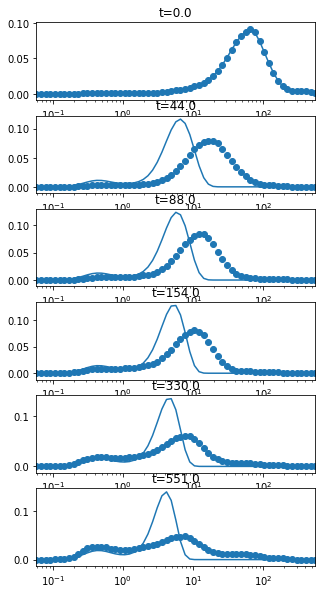

In [63]:
fig, axes = plt.subplots(6,1,figsize=(5,10))
for i in range(6):
    axes[i].plot(L,VV[:,i])
    axes[i].scatter(L,V[:,i])
    axes[i].set_xscale('log')
    axes[i].set_xlim([L[0],L[-1]])
    axes[i].title.set_text('t={0}'.format(T[i]))